# Chapter Three: Hydrological Signature Analysis

## ⚠️ IMPORTANT: Robust Signature Error Calculation

This notebook has been updated to use **safe percentage error calculation** with proper handling of:

1. **Zero-Division Protection**: Near-zero observed values (especially Q95 in ephemeral rivers) now use absolute error instead of exploding to infinity.

2. **Signature-Specific Quality Grades**: Each signature has different tolerances reflecting measurement uncertainty:
   - **Mean Flow**: Strictest (±5% = Excellent) - fundamental water balance
   - **BFI**: Moderate (±10% = Excellent) - subsurface process uncertainty
   - **Q5 (High Flow)**: Moderate (±15% = Excellent) - event-based variability
   - **Q95 (Low Flow)**: Most lenient (±20% = Excellent) - measurement errors at low stage

3. **Physical Interpretation**: See `docs/HYDROLOGICAL_SIGNATURES_INTERPRETATION.md` for guidance on linking errors to:
   - Mean Flow → Precipitation/PET forcing quality
   - BFI → Groundwater representation, geology
   - Q5 → Flood response, routing, snowmelt
   - Q95 → Drought processes, ephemeral rivers, measurement uncertainty

## Key Functions (src/timeseries_stats/hydrological_signatures.py)

- `safe_percentage_error()`: Handles near-zero observed values with epsilon thresholds
- `calculate_signature_errors()`: Computes all four signature errors safely
- `calculate_signature_quality_grades()`: Applies signature-specific 0-3 grading
- `analyze_signature_errors_comprehensive()`: All-in-one analysis function

## Visualization Guidelines

- **Signed errors** (current plots): Use `cmap="seismic"` to show bias direction (red=overestimate, blue=underestimate)
- **Absolute errors**: Use `abs(error_pct)` with `cmap="YlOrRd"` to show magnitude only
- **Quality grades**: Use `list_of_limits=[0,1,2,3]` with categorical labels ["Плох.", "Удов.", "Хор.", "Отл."]

In [1]:
from pathlib import Path
import sys

import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

sys.path.append("../")

from src.analytics.static_analysis import get_cluster_colors
from src.hydro.base_flow import calculate_bfi
from src.hydro.flow_extremes import FlowExtremes
from src.plots.boxplots import create_nse_boxplots
from src.plots.hex_maps import (
    hex_model_distribution_plots_n,
    hexes_plots_n,
)
from src.readers.geom_reader import load_geodata
from src.timeseries_stats.metrics_enhanced import calculate_quality_grades
from src.utils.logger import setup_logger

plt.rcParams["font.family"] = "DeJavu Serif"
plt.rcParams["font.serif"] = ["Times New Roman"]
log = setup_logger("chapter_three", log_file="../logs/chapter_three.log")


In [2]:
table_dir = Path("../res/chapter_three/tables")
table_dir.mkdir(parents=True, exist_ok=True)
image_dir = Path("../res/chapter_three/images")
image_dir.mkdir(parents=True, exist_ok=True)

# Load watershed geometries and gauge locations
ws, gauges = load_geodata(folder_depth="../")
common_index = gauges.index.to_list()
basemap_data = gpd.read_file("../data/geometry/basemap_2023.gpkg")
# Load cluster assignments (from Chapter 1)
gauge_mapping = pd.read_csv(
    "../res/chapter_one/gauge_hybrid_mapping.csv",
    index_col="gauge_id",
    dtype={"gauge_id": str},
)

print(f"Loaded {len(gauges)} gauges with hybrid classification")


Loaded 996 gauges with hybrid classification


### Blind forecast assessments

In [3]:
def read_table_gauge_str(
    table_path: str, index_filter: pd.Index = pd.Index([])
) -> tuple[pd.DataFrame, float]:
    table = pd.read_csv(table_path)
    if "Unnamed: 0" in table.columns:
        table = table.rename(columns={"Unnamed: 0": "gauge_id"})
    table["gauge_id"] = table["gauge_id"].astype(str)
    table = table.set_index("gauge_id")

    if index_filter.empty:
        pass
    else:
        table = table.loc[table.index.isin(index_filter)]
    median_nse = table["NSE"].median()
    return table, median_nse


gauges_partial = gpd.read_file("../data/geometry/partial_gauges.gpkg")
gauges_partial["gauge_id"] = gauges_partial["gauge_id"].astype(str)
gauges_partial = gauges_partial.set_index("gauge_id")
ws_partial = gpd.read_file("../data/geometry/partial_ws.gpkg")
ws_partial.set_index("gauge_id", inplace=True)

era5_blind, lstm_era5_nse = read_table_gauge_str(
    "../archive/conclusions/tables/era5_blind.csv", index_filter=gauges_partial.index
)
era5l_blind, lstm_e5l_nse = read_table_gauge_str(
    "../archive/conclusions/tables/era5l_blind.csv", index_filter=gauges_partial.index
)
gpcp_blind, lstm_gpcp_nse = read_table_gauge_str(
    "../archive/conclusions/tables/gpcp_blind.csv", index_filter=gauges_partial.index
)
mswep_blind, lstm_mswep_nse = read_table_gauge_str(
    "../archive/conclusions/tables/mswep_blind.csv", index_filter=gauges_partial.index
)
lstm_geom_nse = pd.concat(
    [
        mswep_blind.loc[:, "NSE"],
        era5_blind.loc[:, "NSE"],
        era5l_blind.loc[:, "NSE"],
        gpcp_blind.loc[:, "NSE"],
    ],
    axis=1,
)
lstm_geom_nse.columns = [
    "NSE LSTM MSWEP",
    "NSE LSTM ERA5",
    "NSE LSTM ERA5-Land",
    "NSE LSTM GPCP",
]

lstm_geom_nse["geometry"] = gauges_partial.loc[:, ["geometry"]]
lstm_geom_nse = gpd.GeoDataFrame(
    lstm_geom_nse, geometry=lstm_geom_nse["geometry"], crs=4326
)
lstm_geom_nse["Best Meteo NSE"] = lstm_geom_nse[
    ["NSE LSTM MSWEP", "NSE LSTM ERA5", "NSE LSTM ERA5-Land", "NSE LSTM GPCP"]
].max(axis=1)
lstm_ensemble_nse = lstm_geom_nse["Best Meteo NSE"].median()
mswep_index = lstm_geom_nse[
    lstm_geom_nse["Best Meteo NSE"].isin(lstm_geom_nse["NSE LSTM MSWEP"])
].index
era5_index = lstm_geom_nse[
    lstm_geom_nse["Best Meteo NSE"].isin(lstm_geom_nse["NSE LSTM ERA5"])
].index
e5l_index = lstm_geom_nse[
    lstm_geom_nse["Best Meteo NSE"].isin(lstm_geom_nse["NSE LSTM ERA5-Land"])
].index
gpcp_index = lstm_geom_nse[
    lstm_geom_nse["Best Meteo NSE"].isin(lstm_geom_nse["NSE LSTM GPCP"])
].index

for name, index in {
    "MSWEP": mswep_index,
    "ERA5": era5_index,
    "ERA5-Land": e5l_index,
    "GPCP": gpcp_index,
}.items():
    lstm_geom_nse.loc[index, "Лучший метеоисточник"] = name

# Ensure the column with the best reanalysis NSE exists (rename or create)
reanalysis_cols = [
    "NSE LSTM MSWEP",
    "NSE LSTM ERA5",
    "NSE LSTM ERA5-Land",
    "NSE LSTM GPCP",
]

# If the Russian column does not exist, try to rename the English one or compute it
if "NSE LSTM лучший реанализ" not in lstm_geom_nse.columns:
    if "Best Meteo NSE" in lstm_geom_nse.columns:
        lstm_geom_nse = lstm_geom_nse.rename(
            columns={"Best Meteo NSE": "NSE LSTM лучший реанализ"}
        )
    else:
        lstm_geom_nse["NSE LSTM лучший реанализ"] = lstm_geom_nse[reanalysis_cols].max(
            axis=1
        )

# Clip negative NSE values to 0 for all relevant columns
cols_to_clip = ["NSE LSTM лучший реанализ"] + reanalysis_cols
lstm_geom_nse[cols_to_clip] = lstm_geom_nse[cols_to_clip].clip(lower=0.0)

In [4]:
gauges_nse = gauges_partial.copy()
ws_nse = ws_partial.copy()

for col in [
    "NSE LSTM лучший реанализ",
    "NSE LSTM MSWEP",
    "NSE LSTM ERA5",
    "NSE LSTM ERA5-Land",
    "NSE LSTM GPCP",
]:
    ws_nse[col] = lstm_geom_nse.loc[ws_nse.index, col]


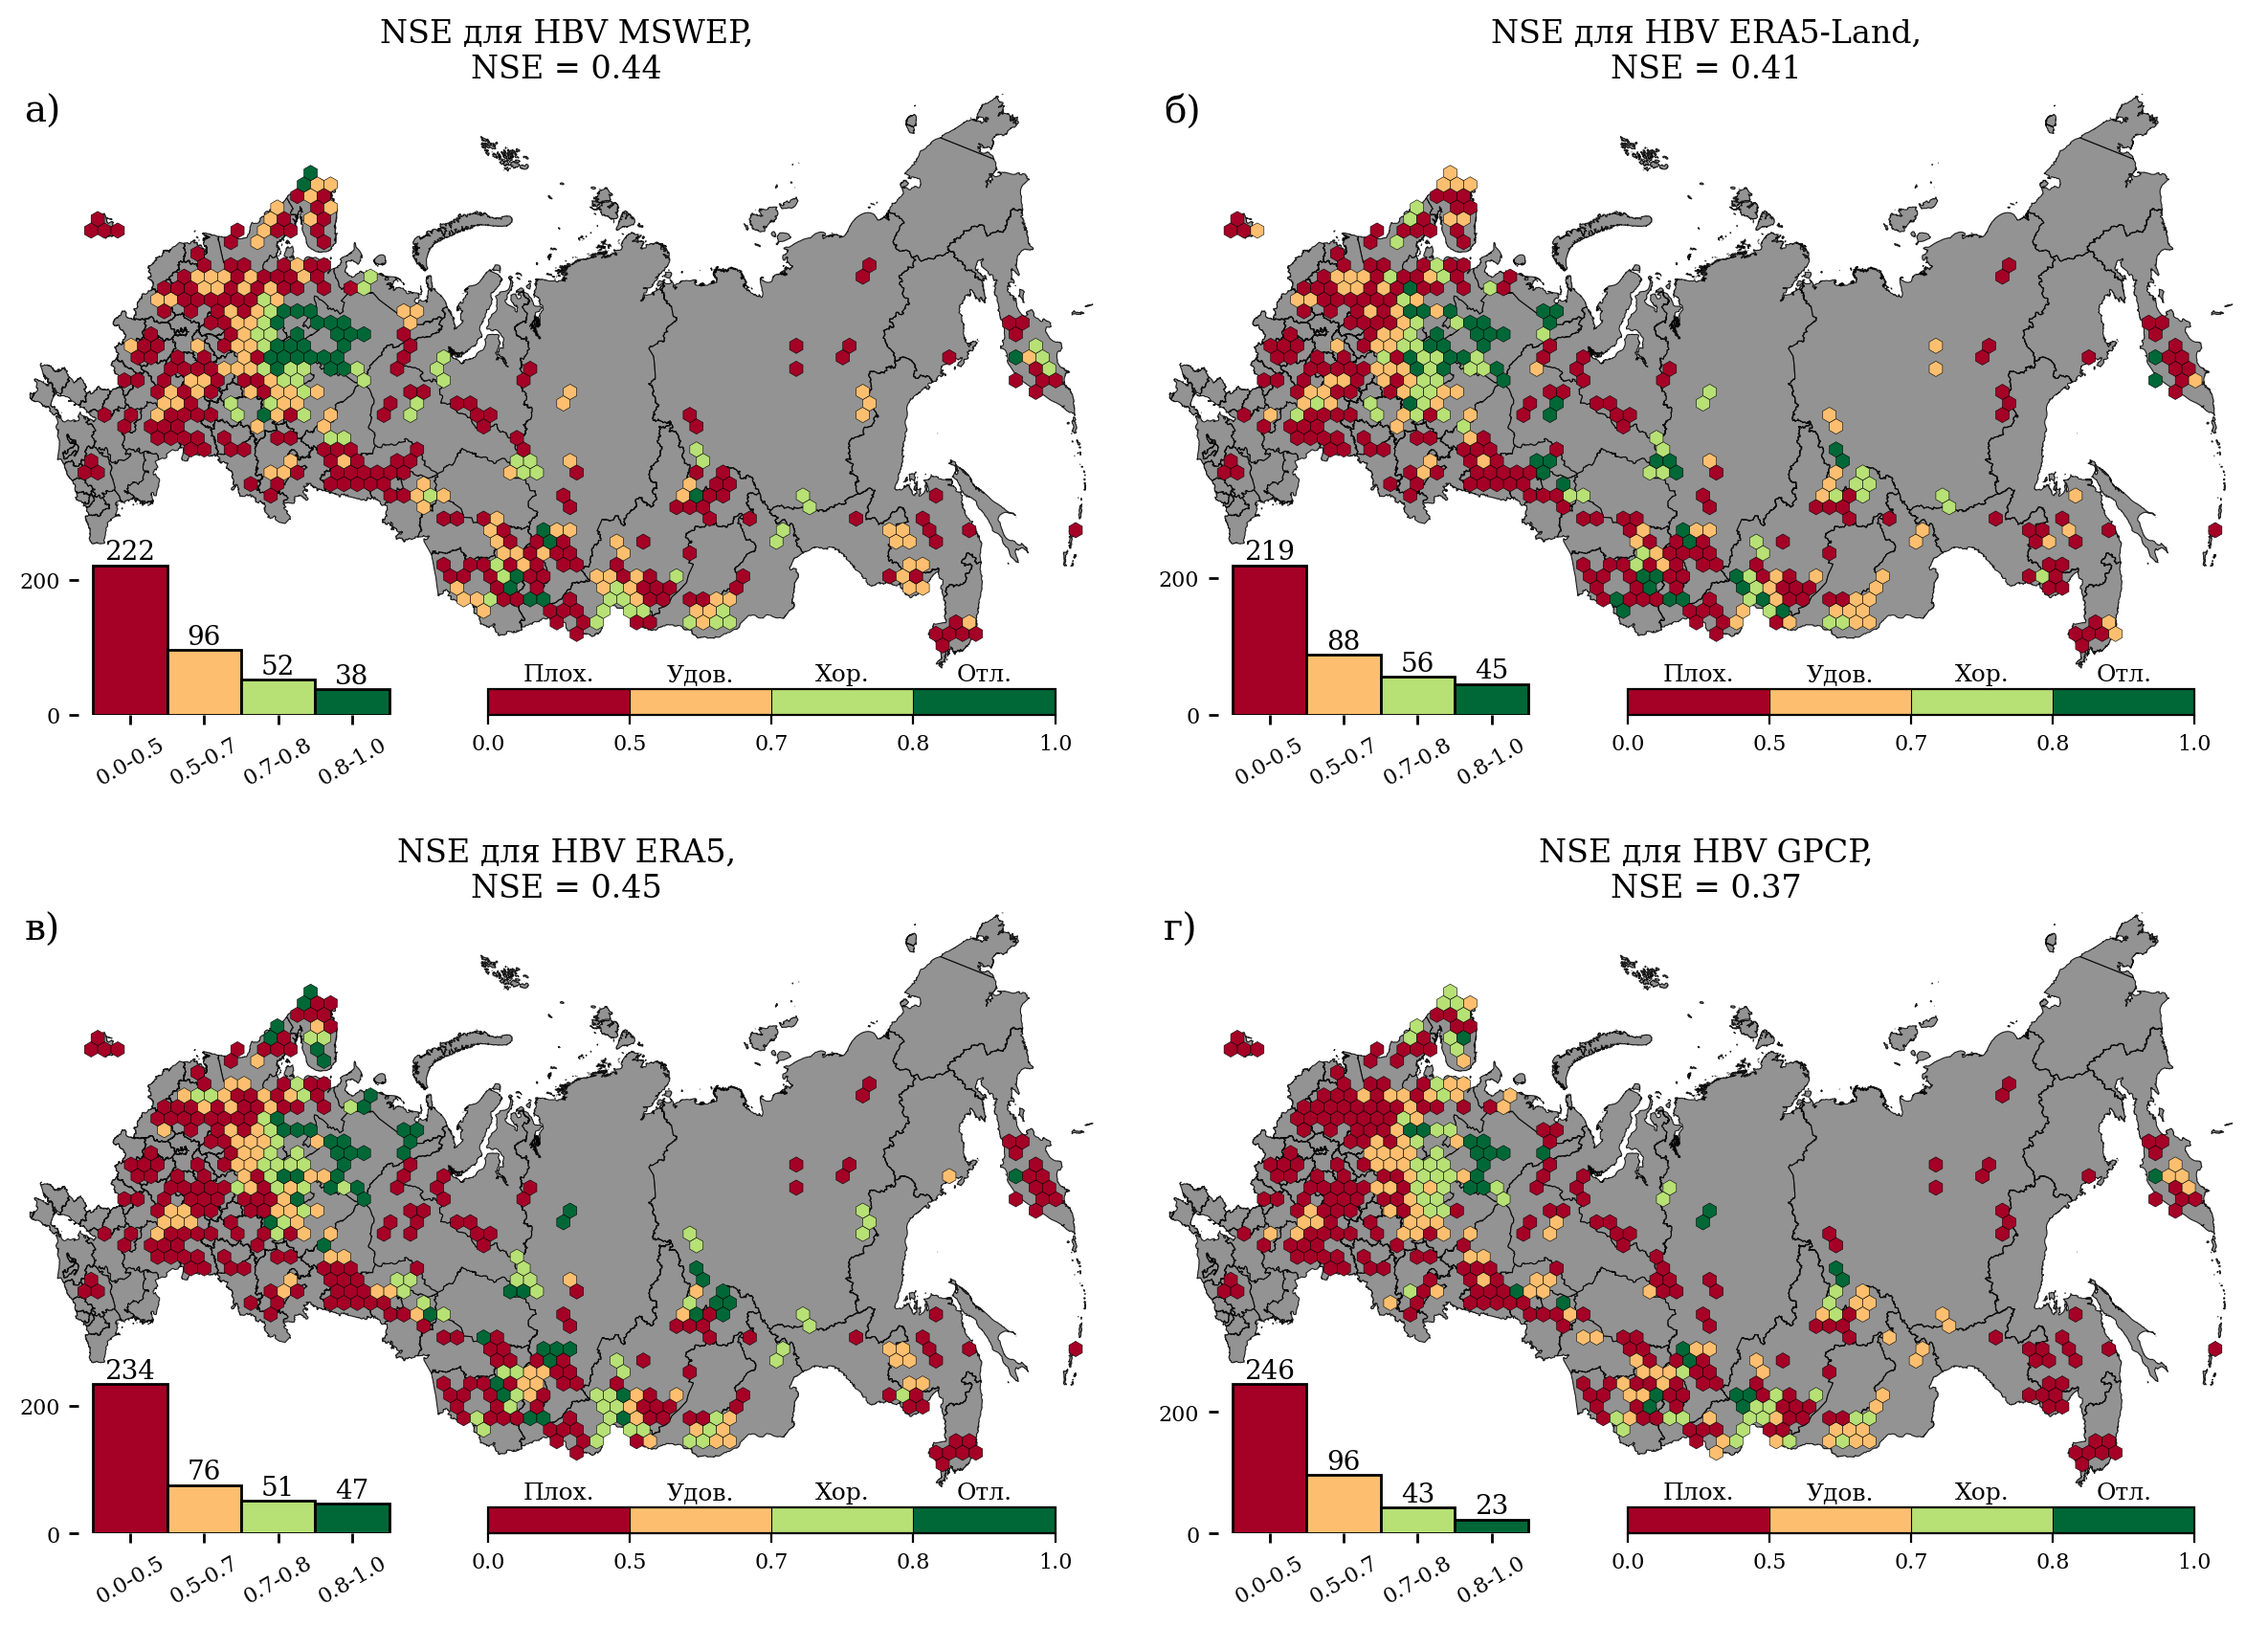

In [5]:
fig, hex_maps, radius_km, coverage_stats = hexes_plots_n(
    watersheds=ws_nse[
        [
            "geometry",
            "NSE LSTM MSWEP",
            "NSE LSTM ERA5",
            "NSE LSTM ERA5-Land",
            "NSE LSTM GPCP",
        ]
    ],
    basemap_data=basemap_data,
    metric_cols=[
        "NSE LSTM MSWEP",
        "NSE LSTM ERA5",
        "NSE LSTM ERA5-Land",
        "NSE LSTM GPCP",
    ],
    label_list=["а)", "б)", "в)", "г)"],
    nrows=2,
    ncols=2,
    target_ws_per_hex=6.0,
    area_weighted=True,
    min_overlap_share=0.15,
    quantile=0.5,
    list_of_limits=[0.0, 0.5, 0.7, 0.8, 1.0],
    figsize=(15, 10),
    basemap_alpha=0.85,
    with_histogram=True,
    cb_label=["Плох.", "Удов.", "Хор.", "Отл."],
    title_text=[
        f"NSE для HBV MSWEP,\nNSE = {lstm_mswep_nse:.2f}",
        f"NSE для HBV ERA5-Land,\nNSE = {lstm_e5l_nse:.2f}",
        f"NSE для HBV ERA5,\nNSE = {lstm_era5_nse:.2f}",
        f"NSE для HBV GPCP,\nNSE = {lstm_gpcp_nse:.2f}",
    ],
)


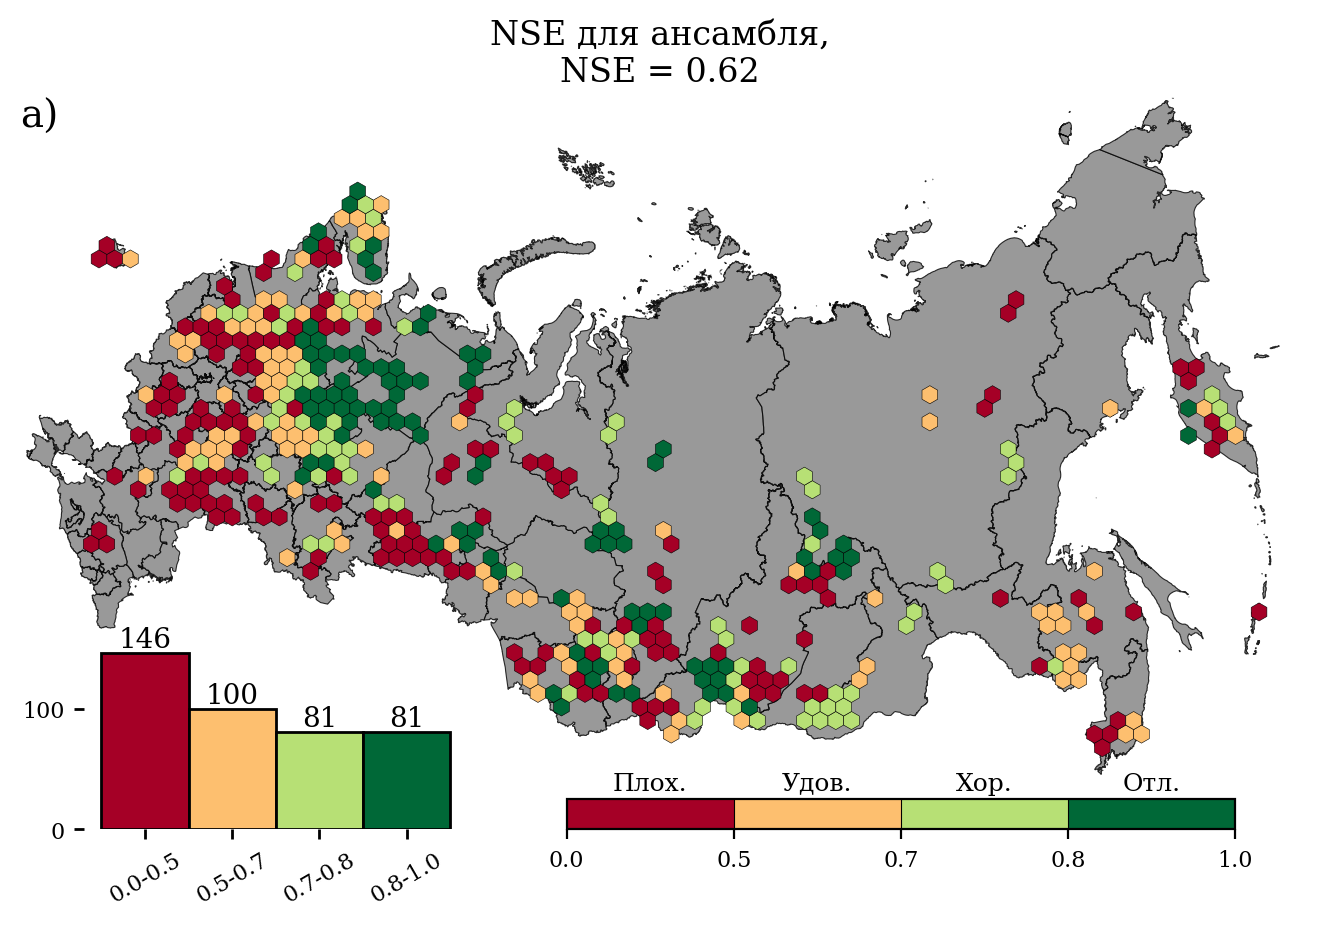

In [6]:
fig, hex_maps, radius_km, coverage_stats = hexes_plots_n(
    watersheds=ws_nse[["geometry", "NSE LSTM лучший реанализ"]],
    basemap_data=basemap_data,
    metric_cols=["NSE LSTM лучший реанализ"],
    label_list=["а)"],
    nrows=1,
    ncols=1,
    target_ws_per_hex=6.0,
    area_weighted=True,
    min_overlap_share=0.15,
    quantile=0.5,
    list_of_limits=[0.0, 0.5, 0.7, 0.8, 1.0],
    figsize=(10, 5),
    basemap_alpha=0.8,
    with_histogram=True,
    cb_label=["Плох.", "Удов.", "Хор.", "Отл."],
    title_text=[
        f"NSE для ансамбля,\nNSE = {lstm_ensemble_nse:.2f}",
    ],
)


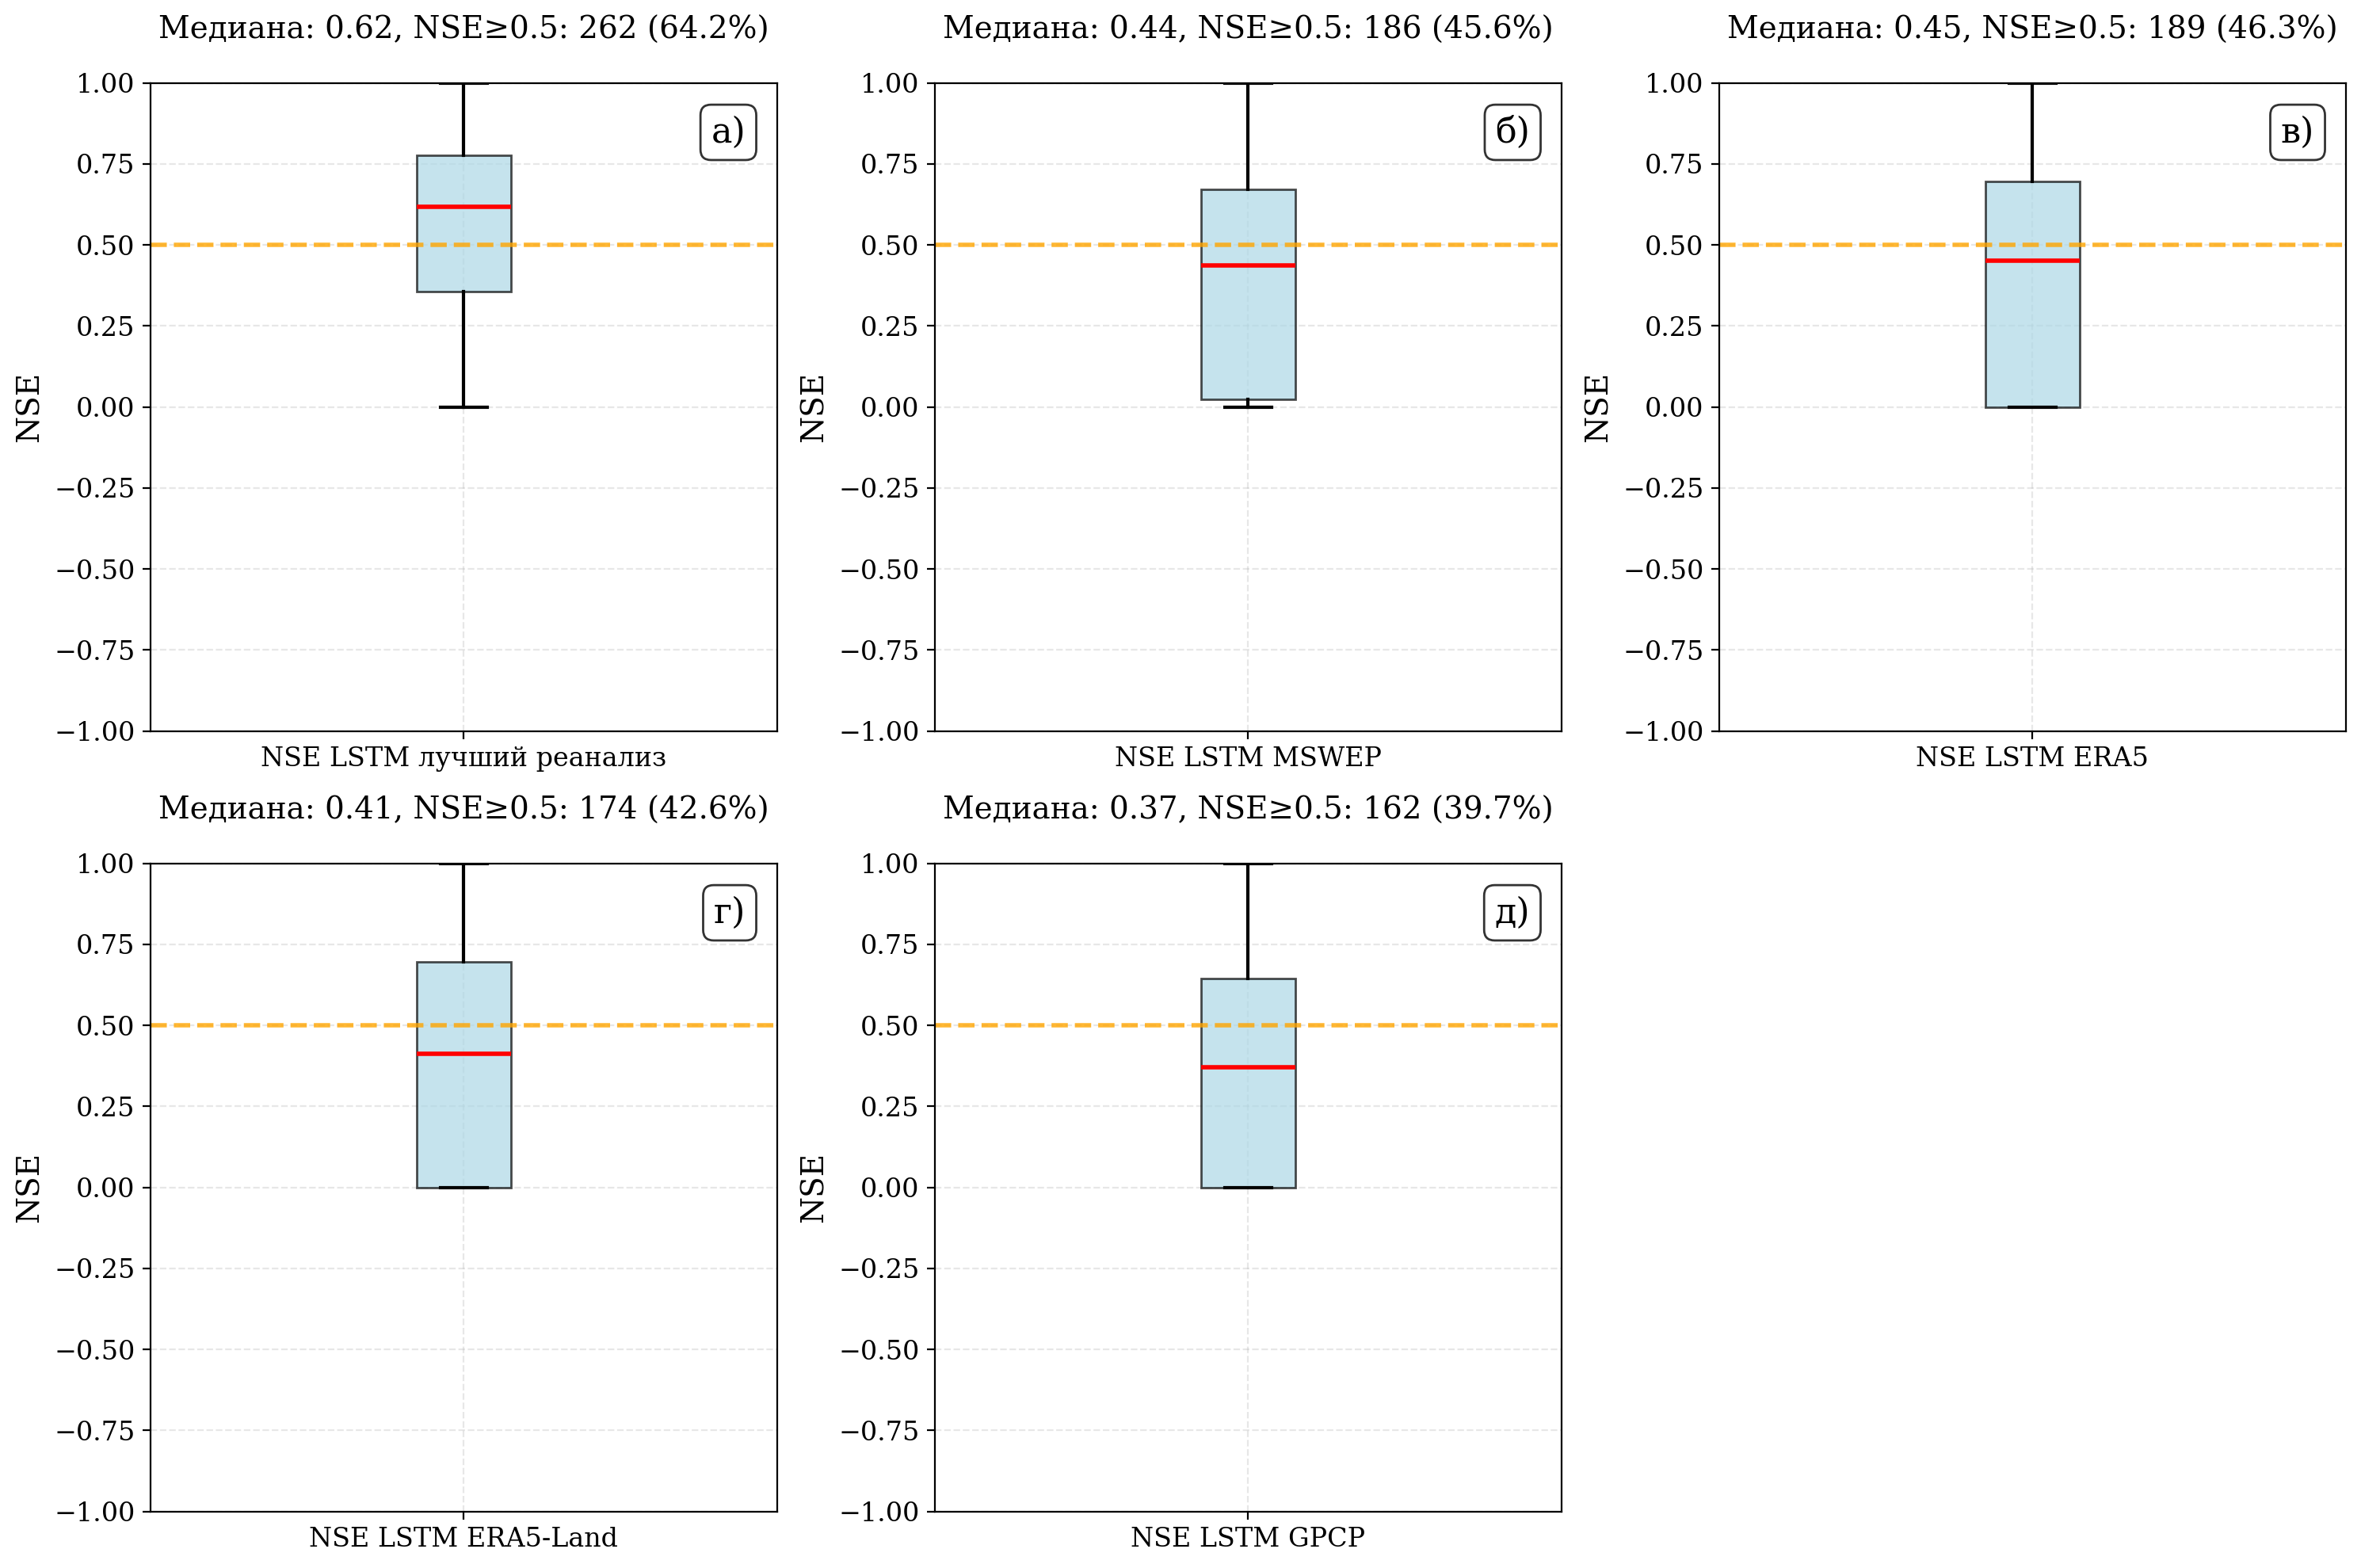

In [7]:
fig = create_nse_boxplots(
    df=lstm_geom_nse,
    nse_columns=[
        "NSE LSTM лучший реанализ",
        "NSE LSTM MSWEP",
        "NSE LSTM ERA5",
        "NSE LSTM ERA5-Land",
        "NSE LSTM GPCP",
    ],
    figsize=(15, 10),
    max_cols=3,
    color="lightblue",
    save_path=f"{image_dir}/LSTM_blind_meteo_5_boxplots.png",
)


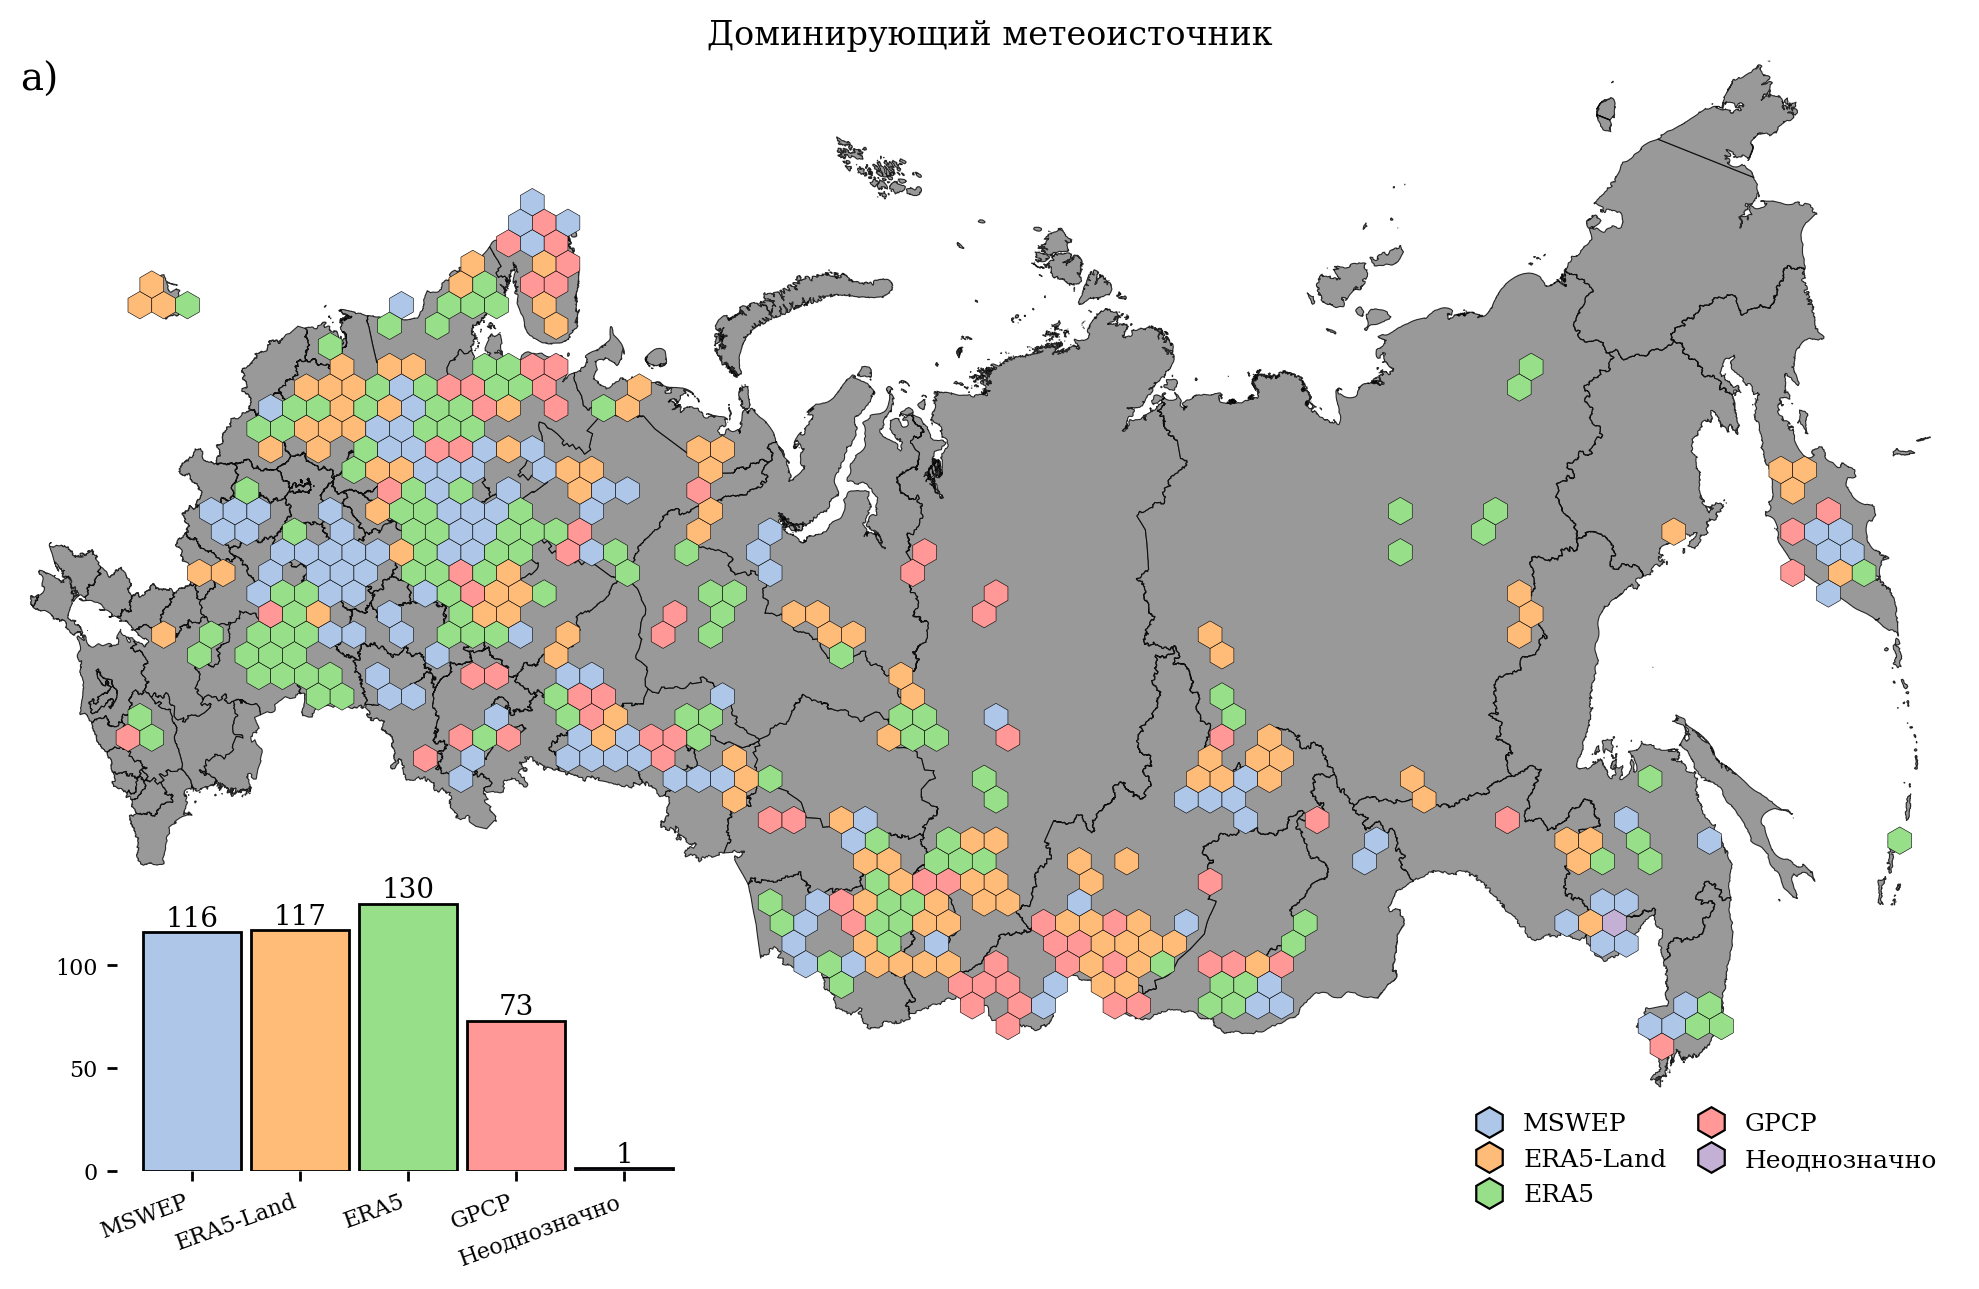

In [8]:
# Copy to watersheds
ws_partial.loc[ws_partial.index, "Лучший метеоисточник"] = lstm_geom_nse.loc[
    ws_partial.index, "Лучший метеоисточник"
]
# Count best meteo distribution
best_meteo_counts = ws_partial["Лучший метеоисточник"].value_counts()
meteo_type_dict = {
    "MSWEP": 1.0,
    "ERA5-Land": 2.0,
    "ERA5": 3.0,
    "GPCP": 4.0,
    "Неоднозначно": 5.0,
}
# Get colors for each category type
_all_colors = get_cluster_colors(n_clusters=20)
_meteo_colors = _all_colors[15:20]

# Side-by-side plot using updated hex_model_distribution_plots_n with per-column dicts
fig_combined, axes, hex_results, counts = hex_model_distribution_plots_n(
    watersheds=ws_partial,
    basemap_data=basemap_data,
    model_cols=["Лучший метеоисточник"],
    model_dict=[meteo_type_dict],  # List of dicts!
    label_list=["а)"],
    nrows=1,
    ncols=1,
    target_ws_per_hex=6.0,
    color_list=[_meteo_colors],  # List of color lists!
    figsize=(10, 8),
    with_histogram=True,
    histogram_rect=[0.05, 0.05, 0.30, 0.24],
    histogram_label_rotation=20,
    legend_show=True,
    legend_kwargs={"loc": "lower right", "bbox_to_anchor": (1.0, 0.0)},
    title_text=[
        "Доминирующий метеоисточник",
    ],
)

### Metrics

#### Metrics by hybrid-cluster

#### Metrics by area

### For full-observation gauges

In [9]:
def split_by_hydro_year(discharge_obs: pd.Series):
    return {
        str(year): discharge_obs[f"10/01/{year}" : f"10/01/{year + 1}"]
        for year in discharge_obs.index.year.unique()
    }


def split_by_year(discharge_obs: pd.Series):
    return {
        str(year): discharge_obs[f"01/01/{year}" : f"12/31/{year}"]
        for year in discharge_obs.index.year.unique()
    }


In [10]:
mswep_pickle = Path(
    "../data/lstm_configs/model_runs/cudalstm_q_mm_day_mswep_no_autocorr_static_1103_191754/test/model_epoch024/test_results.p"
)
gpcp_pickle = Path(
    "../data/lstm_configs/model_runs/cudalstm_q_mm_day_gpcp_no_autocorr_static_1203_080402/test/model_epoch024/test_results.p"
)
era5l_pickle = Path(
    "../data/lstm_configs/model_runs/cudalstm_q_mm_day_era5l_no_autocorr_static_1003_133332/test/model_epoch026/test_results.p"
)
era5_pickle = Path(
    "../data/lstm_configs/model_runs/cudalstm_q_mm_day_era5_no_autocorr_static_1203_220232/test/model_epoch020/test_results.p"
)

# Import new robust signature analysis functions
from src.timeseries_stats.hydrological_signatures import (
    analyze_signature_errors_comprehensive,
)

results_list = []
processed_count = 0
error_count = 0

log.info("Starting hydrological signature analysis with robust error handling...")

for gauge_id in ws.index:
    # Determine which pickle file to use
    if gauge_id in mswep_index:
        pickle_file = mswep_pickle
        dataset = "MSWEP"
    elif gauge_id in gpcp_index:
        pickle_file = gpcp_pickle
        dataset = "GPCP"
    elif gauge_id in era5_index:
        pickle_file = era5_pickle
        dataset = "ERA5"
    else:
        pickle_file = era5l_pickle
        dataset = "ERA5-Land"

    # Load data and convert to float64 for numba compatibility
    df_res = pd.read_pickle(pickle_file)[f"{gauge_id}"]["1D"]["xr"]

    obs = df_res["q_mm_day_obs"].to_numpy().squeeze()[:-1].astype(np.float64)
    sim = df_res["q_mm_day_sim"].to_numpy().squeeze()[:-1].astype(np.float64)
    dates = df_res.date[:-1]

    # Create series with datetime index (required for hydrological functions)
    obs_series = pd.Series(obs, index=dates, name="Observed", dtype=np.float64)
    sim_series = pd.Series(sim, index=dates, name="Simulated", dtype=np.float64)

    # ===== USE NEW ROBUST SIGNATURE ANALYSIS =====
    signature_results = analyze_signature_errors_comprehensive(
        gauge_id=gauge_id, obs_series=obs_series, sim_series=sim_series
    )

    # Add dataset info
    signature_results["dataset"] = dataset

    # ===== ALSO CALCULATE STANDARD METRICS FOR COMPARISON =====
    from src.timeseries_stats.metrics_enhanced import calculate_quality_grades

    standard_grades = calculate_quality_grades(observed=obs, simulated=sim)

    # Merge standard metrics with signature results
    signature_results.update(
        {
            "NSE": standard_grades["NSE"],
            "NSE_grade": standard_grades["NSE_grade"],
            "PBIAS": standard_grades["PBIAS"],
            "PBIAS_grade": standard_grades["PBIAS_grade"],
            "R2": standard_grades["R2"],
            "R2_grade": standard_grades["R2_grade"],
            "composite_score": standard_grades["composite_score"],
            "composite_grade": standard_grades["composite_grade"],
        }
    )

    # ===== ADDITIONAL FLOW EXTREMES (OPTIONAL FOR CONTEXT) =====
    from src.hydro.flow_extremes import FlowExtremes

    obs_extremes = FlowExtremes(obs_series)
    obs_quantiles_extended = obs_extremes.calculate_flow_quantiles(quantiles=[0.01, 0.99])
    obs_high_flows = obs_extremes.analyze_high_flows(threshold_multiplier=2.0)
    obs_low_flows = obs_extremes.analyze_low_flows(threshold_multiplier=0.2)

    sim_extremes = FlowExtremes(sim_series)
    sim_quantiles_extended = sim_extremes.calculate_flow_quantiles(quantiles=[0.01, 0.99])
    sim_high_flows = sim_extremes.analyze_high_flows(threshold_multiplier=2.0)
    sim_low_flows = sim_extremes.analyze_low_flows(threshold_multiplier=0.2)

    # Add extended quantiles and frequencies
    signature_results.update(
        {
            "obs_q1": obs_quantiles_extended["q01_0"],
            "obs_q99": obs_quantiles_extended["q99_0"],
            "obs_high_flow_freq": obs_high_flows["high_flow_frequency"],
            "obs_low_flow_freq": obs_low_flows["low_flow_frequency"],
            "sim_q1": sim_quantiles_extended["q01_0"],
            "sim_q99": sim_quantiles_extended["q99_0"],
            "sim_high_flow_freq": sim_high_flows["high_flow_frequency"],
            "sim_low_flow_freq": sim_low_flows["low_flow_frequency"],
        }
    )

    results_list.append(signature_results)

    processed_count += 1
    if processed_count % 50 == 0:
        log.info(f"Processed {processed_count}/{len(ws.index)} gauges...")


# Convert to DataFrame
final_list = pd.DataFrame(results_list).set_index("gauge_id")

log.info(f"\n{'=' * 80}")
log.info("HYDROLOGICAL SIGNATURE ANALYSIS COMPLETE")
log.info(f"{'=' * 80}")
log.info(f"Successfully processed: {processed_count} gauges")
log.info(f"Errors/Skipped: {error_count} gauges")
log.info("\n=== Signature Error Summary ===")
log.info(f"  Mean Flow Error (median): {final_list['mean_error_pct'].median():+.1f}%")
log.info(f"  BFI Error (median): {final_list['bfi_error_pct'].median():+.1f}%")
log.info(f"  Q5 Error (median): {final_list['q5_error_pct'].median():+.1f}%")
log.info(f"  Q95 Error (median): {final_list['q95_error_pct'].median():+.1f}%")
log.info(f"\n=== Signature Quality Grade Distribution (0-3) ===")
log.info(f"  Mean Flow Grade (avg): {final_list['mean_flow_grade'].mean():.2f}")
log.info(f"  BFI Grade (avg): {final_list['bfi_grade'].mean():.2f}")
log.info(f"  Q5 Grade (avg): {final_list['q5_grade'].mean():.2f}")
log.info(f"  Q95 Grade (avg): {final_list['q95_grade'].mean():.2f}")
log.info(
    f"  Composite Signature Score (avg): {final_list['signature_composite_score'].mean():.2f}/3.0"
)
log.info("\n=== Composite Grade Distribution ===")
for grade in [3, 2, 1, 0]:
    count = (final_list["signature_composite_grade"] == grade).sum()
    pct = (count / len(final_list)) * 100
    grade_labels = ["Poor", "Satisfactory", "Good", "Excellent"]
    log.info(f"  Grade {grade} ({grade_labels[grade]:12s}): {count:3d} ({pct:5.1f}%)")

final_list


2025-12-11 18:59:23 | INFO     | PhDLogger | chapter_three | ℹ️  Starting hydrological signature analysis with robust error handling...
2025-12-11 18:59:25 | WARNING  | PhDLogger | hydrological_signatures | ⚠️  Gauge 8290: Q95 near-zero (0.0092 mm/day). Using absolute error instead of percentage.
2025-12-11 18:59:27 | WARNING  | PhDLogger | hydrological_signatures | ⚠️  Gauge 83260: Q95 near-zero (0.0046 mm/day). Using absolute error instead of percentage.
2025-12-11 18:59:30 | WARNING  | PhDLogger | hydrological_signatures | ⚠️  Gauge 83063: Q95 near-zero (0.0053 mm/day). Using absolute error instead of percentage.
2025-12-11 18:59:31 | INFO     | PhDLogger | chapter_three | ℹ️  Processed 50/996 gauges...
2025-12-11 18:59:32 | WARNING  | PhDLogger | hydrological_signatures | ⚠️  Gauge 5736: Q95 near-zero (0.0081 mm/day). Using absolute error instead of percentage.
2025-12-11 18:59:36 | WARNING  | PhDLogger | hydrological_signatures | ⚠️  Gauge 77362: Q95 near-zero (0.0027 mm/day). Usi

,obs_mean,obs_bfi,obs_q5,obs_q95,sim_mean,sim_bfi,sim_q5,sim_q95,mean_error_pct,bfi_error_pct,...,composite_score,composite_grade,obs_q1,obs_q99,obs_high_flow_freq,obs_low_flow_freq,sim_q1,sim_q99,sim_high_flow_freq,sim_low_flow_freq
gauge_id,,,,,,,,,,,,,,,,,,,,,
70158,0.959114,0.563766,2.956578,0.235529,1.165476,0.582197,3.331924,0.303879,21.515973,3.269421,...,2.000000,2,0.225214,5.911868,19.452055,0.000000,0.280862,5.844878,23.424658,0.000000
8290,0.158337,0.453508,0.819915,0.009157,0.216190,0.655893,0.765844,0.072779,36.537274,44.626681,...,2.000000,2,0.005111,1.486645,21.369863,26.575342,0.068429,1.429860,10.821918,0.000000
70583,1.139368,0.432399,3.657240,0.079041,0.977623,0.608053,2.717588,0.208560,-14.196010,40.623104,...,1.333333,1,0.060321,8.689599,29.452055,29.452055,0.197579,5.254415,20.547945,0.684932
76408,0.628247,0.587279,2.279595,0.173959,0.429074,0.607796,1.652031,0.162017,-31.702900,3.493553,...,0.333333,0,0.159463,3.897983,11.095890,0.821918,0.149044,2.740448,16.849315,0.000000
72668,0.837196,0.755486,1.790580,0.317286,0.945890,0.787661,1.776233,0.353023,12.982986,4.258826,...,1.333333,1,0.302117,2.720695,27.397260,0.000000,0.324317,2.286110,5.205479,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10584,0.250524,0.494470,0.996098,0.017291,0.241820,0.621001,0.868817,0.068240,-3.474590,25.589415,...,1.000000,1,0.011652,1.768731,36.438356,33.424658,0.052577,1.460144,16.164384,0.684932
72577,0.782098,0.647957,2.298318,0.176061,0.655723,0.667321,1.700589,0.190321,-16.158460,2.988438,...,2.000000,2,0.143374,3.118334,30.821918,1.643836,0.169070,2.920134,20.958904,0.000000
8347,0.312856,0.555747,1.107085,0.061923,0.315403,0.710822,0.737046,0.110631,0.814210,27.903988,...,1.000000,1,0.056121,2.170521,18.082192,5.616438,0.104440,1.296520,11.780822,0.000000


In [11]:
# Use the safe calculations from the robust signature analysis
ws_errors = ws.copy()

# Mean flow error (signed percentage for diverging colormap)
ws_errors["Ошибка определения среднего расхода, %"] = final_list.loc[
    ws_errors.index, "mean_error_pct"
]
median_error = final_list["mean_error_pct"].median()

# BFI error (signed percentage)
ws_errors["Ошибка определения индекса базового стока, %"] = final_list.loc[
    ws_errors.index, "bfi_error_pct"
]
median_bfi_error = final_list["bfi_error_pct"].median()

# Q5 error (signed percentage)
ws_errors["Ошибка определения расхода 5-й квантили, %"] = final_list.loc[
    ws_errors.index, "q5_error_pct"
]
median_q5_error = final_list["q5_error_pct"].median()

# Q95 error (signed percentage - already safe!)
ws_errors["Ошибка определения расхода 95-й квантили, %"] = final_list.loc[
    ws_errors.index, "q95_error_pct"
]
median_q95_error = final_list["q95_error_pct"].median()

# Also copy quality grades for analysis
ws_errors["Mean Flow Grade"] = final_list.loc[ws_errors.index, "mean_flow_grade"]
ws_errors["BFI Grade"] = final_list.loc[ws_errors.index, "bfi_grade"]
ws_errors["Q5 Grade"] = final_list.loc[ws_errors.index, "q5_grade"]
ws_errors["Q95 Grade"] = final_list.loc[ws_errors.index, "q95_grade"]
ws_errors["Signature Composite Grade"] = final_list.loc[
    ws_errors.index, "signature_composite_grade"
]

# Log any gauges where Q95 used absolute error (near-zero)
near_zero_q95 = final_list[abs(final_list["obs_q95"]) < 0.01]
if len(near_zero_q95) > 0:
    log.warning(
        f"Found {len(near_zero_q95)} gauges with near-zero Q95 (ephemeral rivers). "
        f"These used absolute error instead of percentage error."
    )
    log.info(f"Ephemeral gauge IDs: {near_zero_q95.index.tolist()[:10]}...")


2025-12-11 19:01:28 | WARNING  | PhDLogger | chapter_three | ⚠️  Found 39 gauges with near-zero Q95 (ephemeral rivers). These used absolute error instead of percentage error.
2025-12-11 19:01:28 | INFO     | PhDLogger | chapter_three | ℹ️  Ephemeral gauge IDs: ['8290', '83260', '83063', '5736', '77362', '10549', '11379', '78499', '3334', '1596']...


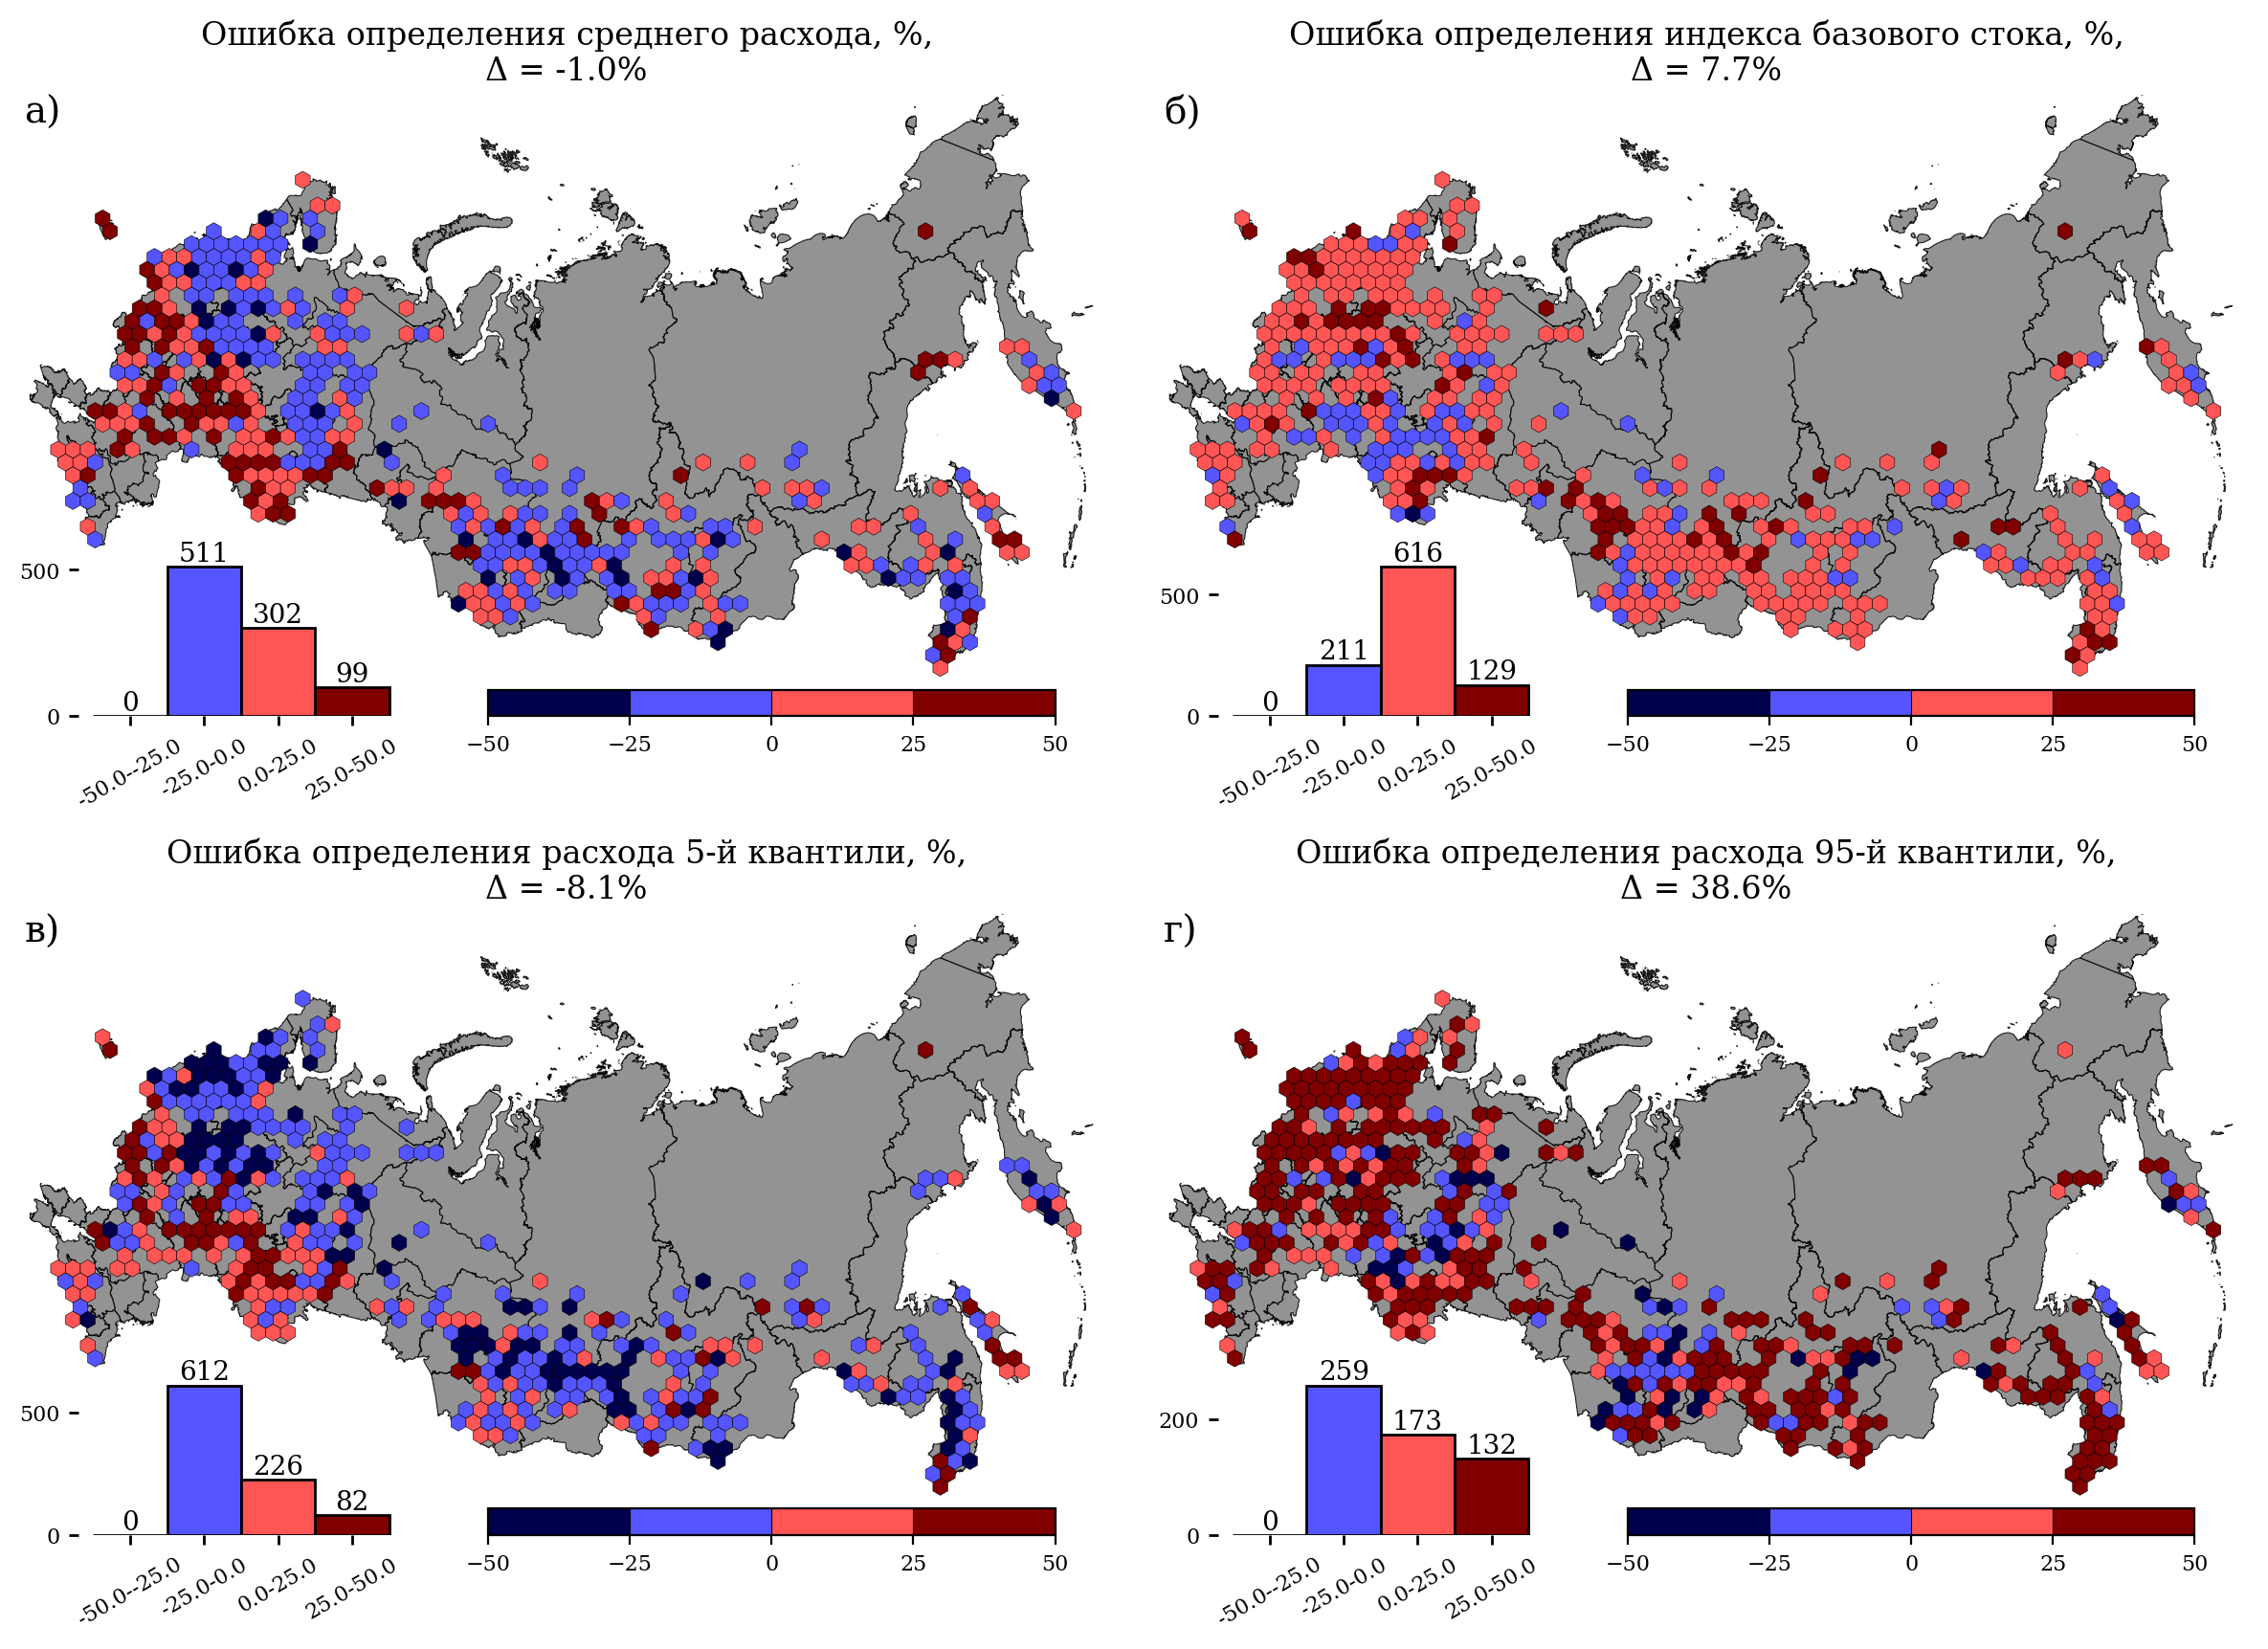

In [12]:
fig, hex_maps, radius_km, coverage_stats = hexes_plots_n(
    watersheds=ws_errors[
        [
            "geometry",
            "Ошибка определения среднего расхода, %",
            "Ошибка определения индекса базового стока, %",
            "Ошибка определения расхода 5-й квантили, %",
            "Ошибка определения расхода 95-й квантили, %",
        ]
    ],
    basemap_data=basemap_data,
    metric_cols=[
        "Ошибка определения среднего расхода, %",
        "Ошибка определения индекса базового стока, %",
        "Ошибка определения расхода 5-й квантили, %",
        "Ошибка определения расхода 95-й квантили, %",
    ],
    label_list=["а)", "б)", "в)", "г)"],
    nrows=2,
    ncols=2,
    target_ws_per_hex=6.0,
    area_weighted=False,
    min_overlap_share=0.15,
    quantile=0.5,
    list_of_limits=[-50, -25, 0, 25, 50],
    cmap_lims=(-50, 50),
    cmap_name="seismic",
    figsize=(15, 10),
    basemap_alpha=0.85,
    with_histogram=True,
    # cb_label=["Плох.", "Удов.", "Хор.", "Отл."],
    title_text=[
        f"Ошибка определения среднего расхода, %,\nΔ = {median_error:.1f}%",
        f"Ошибка определения индекса базового стока, %,\nΔ = {median_bfi_error:.1f}%",
        f"Ошибка определения расхода 5-й квантили, %,\nΔ = {median_q5_error:.1f}%",
        f"Ошибка определения расхода 95-й квантили, %,\nΔ = {median_q95_error:.1f}%",
    ],
)
